In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/RNN_timeseries.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

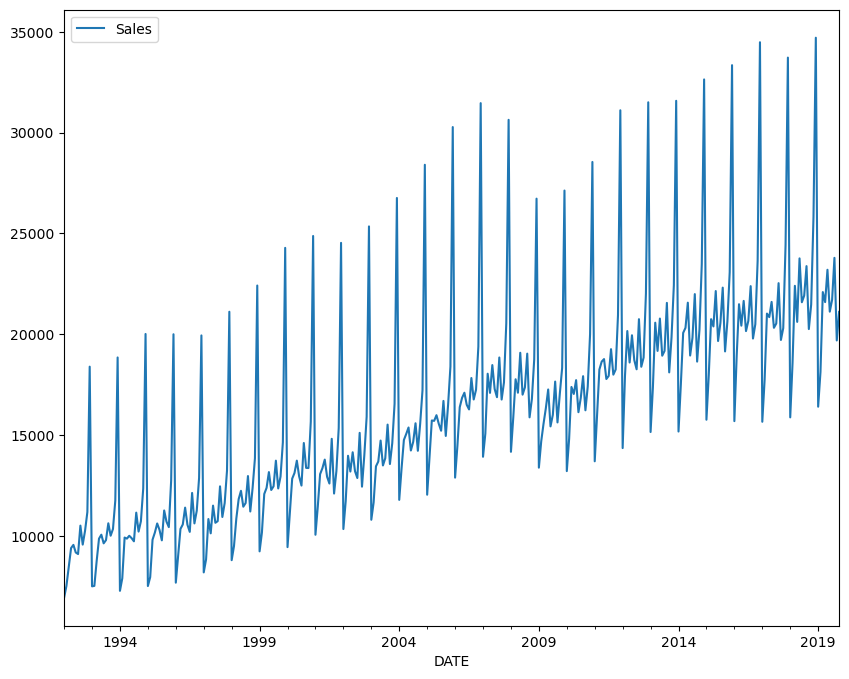

In [5]:
df.columns = ['Sales']
df.plot(figsize = (10,8))

In [6]:
test_size = 18

test_ind = len(df)- test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [7]:
## Scale Data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# We're only using one feature in our time series
n_features = 1

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [12]:
# fit model
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 4s 7ms/step - loss: 0.0261 - val_loss: 0.0025
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0169 - val_loss: 0.0019
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0105 - val_loss: 0.0053
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0063 - val_loss: 8.0566e-04
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0027 - val_loss: 0.0117


<AxesSubplot:>

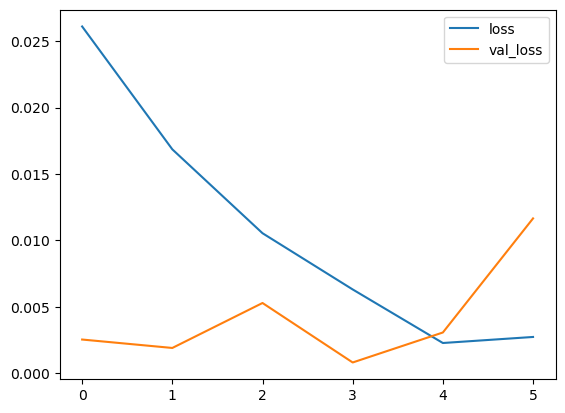

In [13]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [14]:
#Evaluate test batch

test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


C:\Users\Gabbar\AppData\Local\Temp\ipykernel_5196\3687473700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='DATE'>

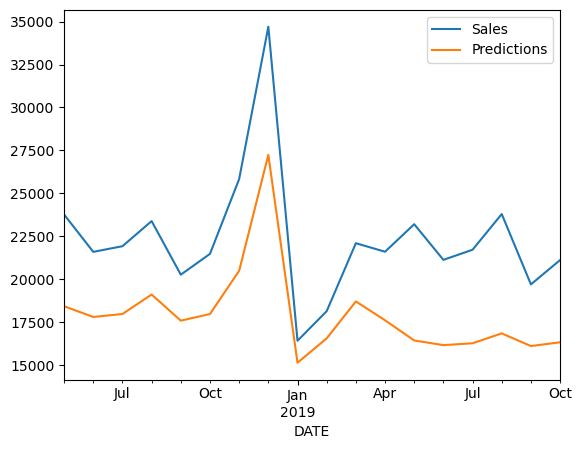

In [15]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot()

In [16]:
# Retrain and Forecasting

full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit(generator,epochs=8)

forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

Epoch 1/8
322/322 [==============================] - 3s 6ms/step - loss: 0.0250
Epoch 2/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0168
Epoch 3/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0083
Epoch 4/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0038
Epoch 5/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 6/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 7/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0022
Epoch 8/8
1/1 [==============================] - 0s 33ms/step


<AxesSubplot:>

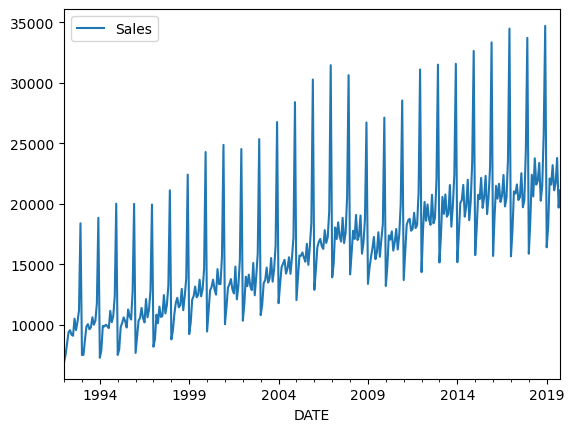

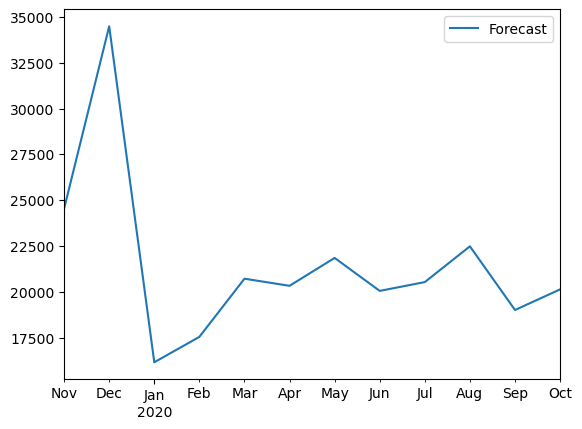

In [17]:
df.plot()
forecast_df.plot()

(576.0, 611.0)

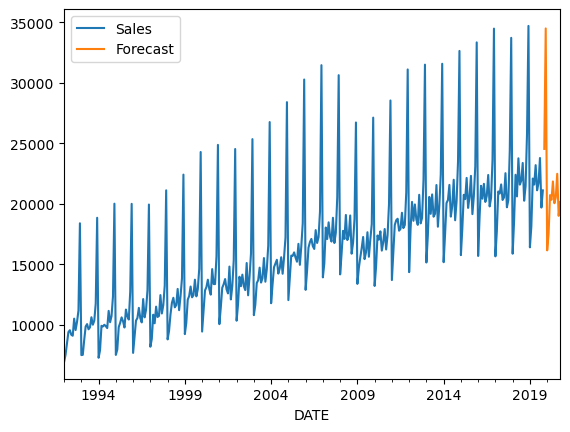

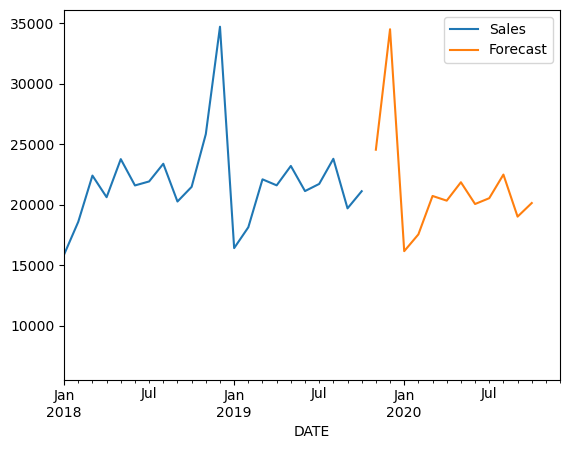

In [18]:
### Joining pandas plots
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

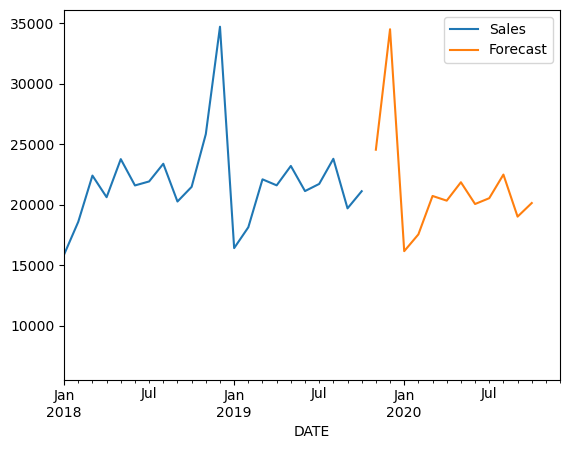

In [19]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')